### Init

In [0]:
pip install geopandas

In [0]:
import os
import json
import pandas as pd
import shutil
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_mexican_review = pd.read_csv('/content/drive/My Drive/STAT628/data/mexican_review.csv')
df_mexican_tip =pd.read_csv('/content/drive/My Drive/STAT628/data/mexican_tip.csv')
df_mexican_info = pd.read_csv('/content/drive/My Drive/STAT628/data/mexican_info.csv')
df_business = pd.read_csv('/content/drive/My Drive/STAT628/data/business.csv')

In [0]:
df_mexican_info.head()

,business_id,name,city,latitude,longitude,star,review_count,attribute,address
0,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,33.495194,-112.028588,3.0,18,"RestaurantsTakeOut,BusinessAcceptsCreditCards,...",2450 E Indian School Rd
1,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,Las Vegas,36.195615,-115.040529,4.5,184,"BikeParking,BusinessAcceptsCreditCards,GoodFor...",6055 E Lake Mead Blvd
2,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,Toronto,43.666181,-79.316468,3.5,43,"RestaurantsGoodForGroups,RestaurantsTakeOut,Bi...",1614 Queen Street E
3,voZnDQs6Hs3YpNcS-9TALg,New Mexican Grill,Chandler,33.261325,-111.790815,4.0,84,"GoodForKids,BikeParking,BusinessAcceptsCreditC...","3140 S Gilbert Rd, Ste 3"
4,jScBTQtdAt-8RshaiBEHgw,Served,Henderson,36.010745,-115.064803,4.5,664,"RestaurantsGoodForGroups,WheelchairAccessible,...","1770 W Horizon Ridge, Ste 100"


### Mexican Food Popularity Analysis

In [0]:
sns.set(style="whitegrid", color_codes=True)

In [0]:
cities = df_mexican_info.city.unique()
city_res_count = []
city_reviews_count = []
city_reviews_count_all = []
city_latitude = []
city_longitude = []
city_star = []
for city in cities:
    city_reviews_count.append(df_mexican_info[df_mexican_info['city'] == city].review_count.sum())
    city_res_count.append(df_mexican_info[df_mexican_info['city'] == city].shape[0])
    city_reviews_count_all.append(df_business[df_business['city'] == city].review_count.sum())
    city_latitude.append(df_mexican_info[df_mexican_info['city'] == city].latitude.mean())
    city_longitude.append(df_mexican_info[df_mexican_info['city'] == city].longitude.mean())
    city_star.append(df_mexican_info[df_mexican_info['city'] == city].star.mean())

city_mex_heat = []
for i in range(len(cities)):
    city_mex_heat.append(city_reviews_count[i]/city_reviews_count_all[i])

In [0]:
df_heat = pd.DataFrame({'city':cities,
                        'restaurant_count': city_res_count,
                        'latitude': city_latitude,
                        'longitude': city_longitude,
                        'review_count_mex': city_reviews_count,
                        'review_count_all': city_reviews_count_all,
                        'star': city_star,
                        'heat': city_mex_heat})
# df_heat.sort_values('review_count_mex', inplace = True, ascending = False)
df_heat.sort_values('heat', inplace = True, ascending = True)
# df_heat.sort_values('review_count_mex', inplace = True, ascending = False)
df_heat = df_heat[df_heat['review_count_all']>=5000]

In [0]:
df_heat.head(5)

,city,restaurant_count,latitude,longitude,review_count_mex,review_count_all,star,heat
215,Thornhill,1,43.798610,-79.420694,7,8351,2.50,0.000838
133,Spring Valley,1,36.129184,-115.092329,4,1486,4.50,0.002692
136,Markham,6,43.859904,-79.304069,164,49568,3.25,0.003309
118,North York,4,43.699889,-79.458372,71,19658,3.50,0.003612
219,Pointe-Claire,1,45.468182,-73.824683,4,1034,3.00,0.003868


In [0]:
df_heat.to_csv('/content/drive/My Drive/STAT628/data/heat.csv', index = False)

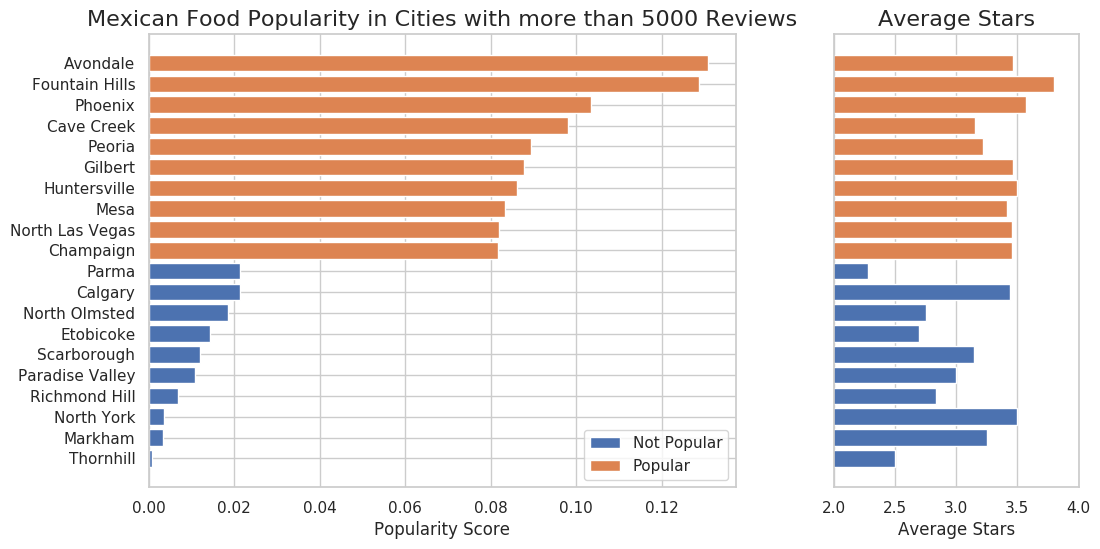

In [0]:
df_heat.sort_values('heat', inplace = True, ascending = True)
df_heat = df_heat[df_heat['review_count_all']>=5000]

fig, ax = plt.subplots(figsize=(12,6), dpi= 100)
grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, :2])
plt.barh(df_heat.head(10).city.values, df_heat.head(10).heat.values, label = 'Not Popular')
plt.barh(df_heat.tail(10).city.values, df_heat.tail(10).heat.values, label = 'Popular')
plt.xlabel('Popularity Score')
plt.title('Mexican Food Popularity in Cities with more than 5000 Reviews', fontsize=16)
plt.legend(loc = 'lower right')

plt.subplot(grid[0, 2:])
plt.barh(df_heat.head(10).city.values, df_heat.head(10).star.values, label = 'Not Popular')
plt.barh(df_heat.tail(10).city.values, df_heat.tail(10).star.values, label = 'Popular')
plt.xlabel('Popularity Score')
plt.title('Average Stars', fontsize=16)
plt.xlabel('Average Stars')
plt.yticks([])
plt.xlim(2,4)

plt.savefig('/content/drive/My Drive/STAT628/figure/popularity.png', dpi = 100)
plt.show()

In [0]:
### Heat Map of Mexican Food

max_amount = float(df_heat['heat'].max())
hmap = folium.Map(location=[50, -90], zoom_start=5)
hm_wide = HeatMap(list(zip(df_heat.latitude.values, 
                           df_heat.longitude.values, 
                           df_heat.heat.values)),
                  min_opacity=0.1,
                  max_val=max_amount,
                  radius=30, blur=35, 
                  max_zoom=5)

hmap.add_child(hm_wide)

### Review Trend Analysis

#### Mexican Trend

In [0]:
df_review_seg = df_mexican_review[['stars', 'date']]
date = df_review_seg['date'].values.tolist()
for i in range(len(date)):
    date[i] = date[i][0:7]
df_review_seg['date'] = date

df_counts = df_review_seg.groupby(['stars', 'date']).size().reset_index(name='counts')
date = list(df_counts.date.unique())
date.sort()
def count_review(df):
    y = []
    for i in range(len(date)):
        try:
            cnt = df[df['date']==date[i]].counts.values[0]
            y.append(cnt)
        except:
            y.append(0)
    return y

y1 = count_review(df_counts[df_counts['stars']==1.0])
y2 = count_review(df_counts[df_counts['stars']==2.0])
y3 = count_review(df_counts[df_counts['stars']==3.0])
y4 = count_review(df_counts[df_counts['stars']==4.0])
y5 = count_review(df_counts[df_counts['stars']==5.0])

date.insert(1, '2005-01')
y1.insert(1, 0)
y2.insert(1, 0)
y3.insert(1, 0)
y4.insert(1, 0)
y5.insert(1, 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


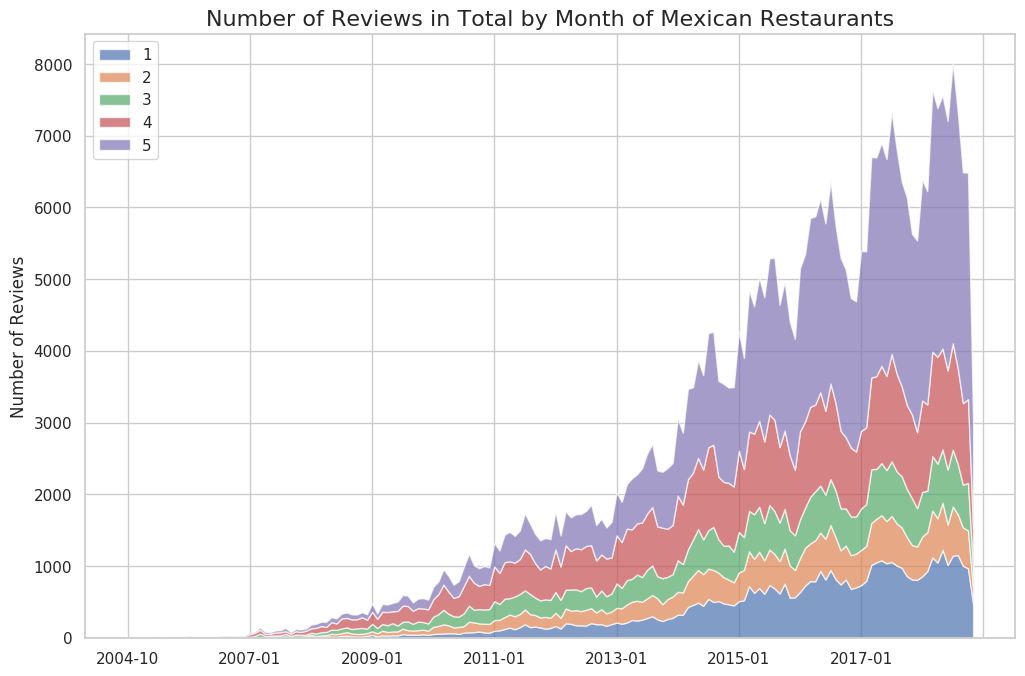

In [0]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12,8), dpi= 100)
ax = plt.gca()
ax.stackplot(date, y1, y2, y3, y4, y5, labels = ['1', '2', '3', '4', '5'], alpha = 0.7)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
plt.title('Number of Reviews in Total by Month of Mexican Restaurants', fontsize=16)
plt.ylabel('Number of Reviews')
plt.legend(loc = 'upper left')

plt.savefig('/content/drive/My Drive/STAT628/figure/trend_Mexican.png', dpi = 100)
plt.show()

#### General Trend

In [0]:
df_review = pd.read_csv('/content/drive/My Drive/STAT628/data/review.csv')
df_review_seg = df_review[['stars', 'date']]
date = df_review_seg['date'].values.tolist()
for i in range(len(date)):
    date[i] = date[i][0:7]
df_review_seg['date'] = date

df_counts = df_review_seg.groupby(['stars', 'date']).size().reset_index(name='counts')
date = list(df_counts.date.unique())
date.sort()
def count_review(df):
    y = []
    for i in range(len(date)):
        try:
            cnt = df[df['date']==date[i]].counts.values[0]
            y.append(cnt)
        except:
            y.append(0)
    return y

y1 = count_review(df_counts[df_counts['stars']==1.0])
y2 = count_review(df_counts[df_counts['stars']==2.0])
y3 = count_review(df_counts[df_counts['stars']==3.0])
y4 = count_review(df_counts[df_counts['stars']==4.0])
y5 = count_review(df_counts[df_counts['stars']==5.0])

date.insert(1, '2005-01')
y1.insert(1, 0)
y2.insert(1, 0)
y3.insert(1, 0)
y4.insert(1, 0)
y5.insert(1, 0)

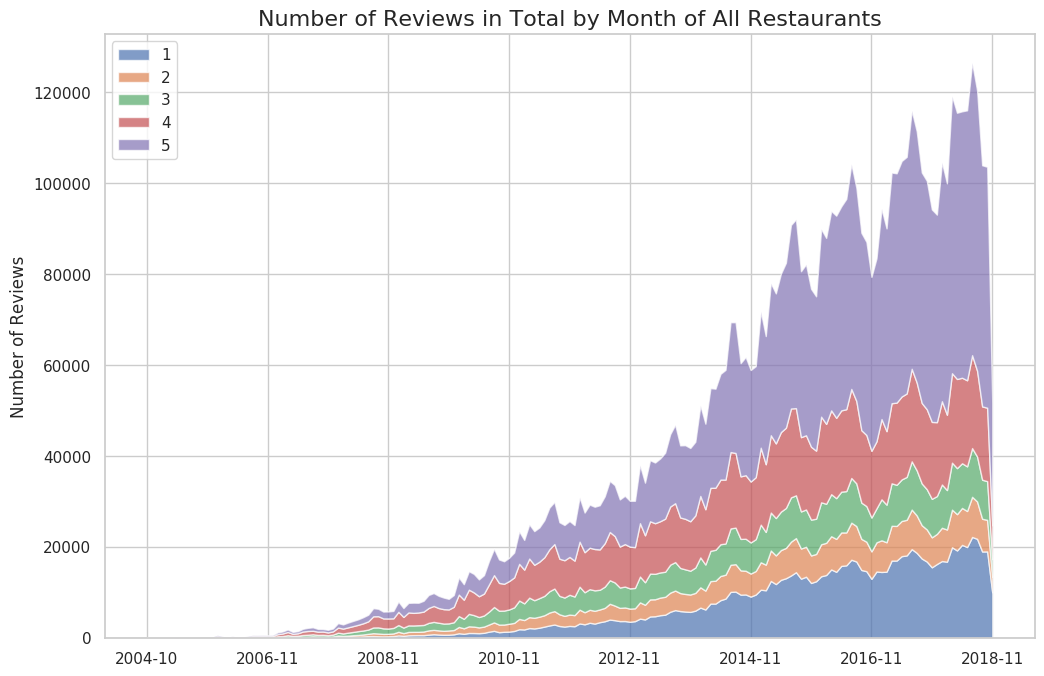

In [0]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12,8), dpi= 100)
ax = plt.gca()
ax.stackplot(date, y1, y2, y3, y4, y5, labels = ['1', '2', '3', '4', '5'], alpha = 0.7)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
plt.title('Number of Reviews in Total by Month of All Restaurants', fontsize=16)
plt.ylabel('Number of Reviews')
plt.legend(loc = 'upper left')

plt.savefig('/content/drive/My Drive/STAT628/figure/trend_All.png', dpi = 100)
plt.show()